### Understanding Girvan-Newman Assortiative Mixing Model

In [199]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Get the edge count from the mixing matrix and the poisson coeffients. Set the seed to a fixed value so that you get the same number each time.

In [200]:
%autoreload 2

from Girvan_Newman_stochastic_block_network_v3 import AssortativeMixing
import numpy as np
from numpy.typing import NDArray


M: NDArray[np.float32] = np.array([[0.4, 0.01],
                                   [0.01, 0.4]]) 
poisson_lambda: list[int] = [6, 4]
num_edges: int = 50
seed =42

assortative_network: AssortativeMixing = AssortativeMixing(M, poisson_lambda)


In [201]:
edge_count_by_type = assortative_network._draw_edges_from_mixing_matrix(M, num_edges, seed=seed)
print(edge_count_by_type)

{(0, 0): 25, (0, 1): 2, (1, 0): 1, (1, 1): 22}


Count the number of stubs of each type required. There should be 
- type 0: 25*2 + 2 + 1 = 53
- type 1: 2 + 1 + 2*22 = 47

In [202]:
num_classes: int = len(M)
stubs_per_class = assortative_network._get_number_of_stubs_per_class(edge_count_by_type, num_classes)
print(stubs_per_class)

{0: 53, 1: 47}


Generate nodes of each type with degree randomly drawn from a Poisson distribution. Seed the distribution so that results are replicable. The number of nodes of each type is determined by dividing the number of stubs of each class by the average degree of nodes in the class. We're using a Poisson distribution for node degree so the average node degree is lambda. 

We expect that the number of nodes is
- class 0 is  53/6 rounded up, which is 9 
- class 1 is 47/4 = 12

In [203]:
for node_class in stubs_per_class.keys():
    num_required_nodes = assortative_network._get_number_nodes_in_class(stubs_per_class[node_class],
                                                                    poisson_lambda[node_class])
    print(f"number of nodes of class {node_class} is {num_required_nodes}")

number of nodes of class 0 is 9
number of nodes of class 1 is 12


generate a list of nodes with a fixed seed for each class and add the list to a dictionary indexed by class

In [204]:
starting_node_id: int = 0
for node_class in stubs_per_class.keys():
    num_required_nodes = assortative_network._get_number_nodes_in_class(stubs_per_class[node_class],
                                                                    poisson_lambda[node_class])
    node_list = assortative_network._create_nodes_for_class(node_class,
                                                  num_required_nodes,
                                                  poisson_lambda[node_class],
                                                  starting_node_id,
                                                  seed=seed)
    print(f"node list for class {node_class} is:")
    print(f"   {[node.ID for node in node_list]}")
    print("which have degrees")
    print(f"   {[node.degree for node in node_list]}")
    print("and difference between required stubs and actual stubs of ")
    print(f"   {stubs_per_class[node_class]} - {sum([node.degree for node in node_list])}")
    starting_node_id += len(node_list)

node list for class 0 is:
   [0, 1, 2, 3, 4, 5, 6, 7, 8]
which have degrees
   [6, 6, 4, 5, 4, 6, 4, 4, 9]
and difference between required stubs and actual stubs of 
   53 - 48
node list for class 1 is:
   [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
which have degrees
   [5, 4, 4, 4, 2, 5, 2, 5, 3, 5, 7, 1]
and difference between required stubs and actual stubs of 
   47 - 47


Resample degree until required number of stubs equals actual stubs

In [205]:
starting_node_id = 0
for node_class in stubs_per_class.keys():
    num_required_nodes = assortative_network._get_number_nodes_in_class(stubs_per_class[node_class],
                                                                    poisson_lambda[node_class])
    node_list = assortative_network._create_nodes_for_class(node_class,
                                                  num_required_nodes,
                                                  poisson_lambda[node_class],
                                                  starting_node_id,
                                                  seed=seed)
    node_list = assortative_network._resample_node_degrees_in_nodelist(node_list,
                                                                       stubs_per_class[node_class],
                                                                       poisson_lambda[node_class],
                                                                       seed=seed)
    starting_node_id += len(node_list)
    print(f"node list for class {node_class} is:")
    print(f"   {[node.ID for node in node_list]}")
    print("which have degrees")
    print(f"   {[node.degree for node in node_list]}")
    print("and difference between required stubs and actual stubs of ")
    print(f"   {stubs_per_class[node_class]} - {sum([node.degree for node in node_list])}")

node list for class 0 is:
   [0, 1, 2, 3, 4, 5, 6, 7, 8]
which have degrees
   [8, 6, 3, 9, 8, 6, 4, 4, 5]
and difference between required stubs and actual stubs of 
   53 - 53
node list for class 1 is:
   [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
which have degrees
   [5, 4, 4, 4, 2, 5, 2, 5, 3, 5, 7, 1]
and difference between required stubs and actual stubs of 
   47 - 47


Make sure that the dictionary of nodelists of each time is populated

In [206]:
from Girvan_Newman_stochastic_block_network_v3 import Node_Type
starting_node_id = 0
all_nodes: list[Node_Type] = []
for node_class in stubs_per_class.keys():
    num_required_nodes = assortative_network._get_number_nodes_in_class(stubs_per_class[node_class],
                                                                        poisson_lambda[node_class])
    node_list = assortative_network._create_nodes_for_class(node_class,
                                                  num_required_nodes,
                                                  poisson_lambda[node_class],
                                                  starting_node_id,
                                                  seed=seed)
    node_list = assortative_network._resample_node_degrees_in_nodelist(node_list,
                                                                       stubs_per_class[node_class],
                                                                       poisson_lambda[node_class],
                                                                       seed=seed)
    all_nodes.extend(node_list)
    starting_node_id += len(node_list)
for node in all_nodes:
    print(f"node {node.ID} has node degrees {node.degree}")

node 0 has node degrees 8
node 1 has node degrees 6
node 2 has node degrees 3
node 3 has node degrees 9
node 4 has node degrees 8
node 5 has node degrees 6
node 6 has node degrees 4
node 7 has node degrees 4
node 8 has node degrees 5
node 9 has node degrees 5
node 10 has node degrees 4
node 11 has node degrees 4
node 12 has node degrees 4
node 13 has node degrees 2
node 14 has node degrees 5
node 15 has node degrees 2
node 16 has node degrees 5
node 17 has node degrees 3
node 18 has node degrees 5
node 19 has node degrees 7
node 20 has node degrees 1


Now check that the function that does all these steps returns the same thing.

In [207]:
all_nodes = assortative_network._create_nodes(stubs_per_class, 
                                                        poisson_lambda,
                                                      seed=seed)
total_degree: int = 0
for node in all_nodes:
    print(f"node {node.ID} has node degrees {node.degree}")
    total_degree += node.degree
print(f"total degree of nodes is {total_degree}")


node 0 has node degrees 8
node 1 has node degrees 6
node 2 has node degrees 3
node 3 has node degrees 9
node 4 has node degrees 8
node 5 has node degrees 6
node 6 has node degrees 4
node 7 has node degrees 4
node 8 has node degrees 5
node 9 has node degrees 5
node 10 has node degrees 4
node 11 has node degrees 4
node 12 has node degrees 4
node 13 has node degrees 2
node 14 has node degrees 5
node 15 has node degrees 2
node 16 has node degrees 5
node 17 has node degrees 3
node 18 has node degrees 5
node 19 has node degrees 7
node 20 has node degrees 1
total degree of nodes is 100


---

### Adding Edges

#### Step 1: Wire

**Step 1.0:** Look at the degree of each node

**Step 1.1:** Create list of edge types with repeats

In [208]:
wired_edges: dict[tuple[int,int],list[tuple[Node_Type, Node_Type]]] = {edge_type: [] for edge_type in edge_count_by_type.keys()}
unwired_edge_types: list[tuple[int,int]] = []
edge_types_with_repeats: list[tuple[int,int]] = []

# Step 1: Creat a list of all edge types with repeats
for edge_type, num_edges in edge_count_by_type.items():
    edge_types_with_repeats.extend([edge_type for _ in range(num_edges)])

# Check whether we have allocated the edge types correctly
for edge_type in edge_count_by_type.keys():
    print(f"edge type {edge_type} required {edge_count_by_type[edge_type]} nodes")
    print(f"and there are {len([edge_types_with_repeats for edge in edge_types_with_repeats if edge[0] == edge_type[0] and edge[1]==edge_type[1]])} repeats")


edge type (0, 0) required 25 nodes
and there are 25 repeats
edge type (0, 1) required 2 nodes
and there are 2 repeats
edge type (1, 0) required 1 nodes
and there are 1 repeats
edge type (1, 1) required 22 nodes
and there are 22 repeats


**Step 1.2:** Shuffle to introduce randomness

In [209]:
import random
random.seed(1234)
random.shuffle(edge_types_with_repeats)

print([edge_types_with_repeats[i] for i in range(8)])

# Check whether shuffling caused problems
# Check whether we have allocated the edge types correctly
for edge_type in edge_count_by_type.keys():
    print(f"edge type {edge_type} required {edge_count_by_type[edge_type]} nodes")
    print(f"and there are {len([edge_types_with_repeats for edge in edge_types_with_repeats if edge[0] == edge_type[0] and edge[1]==edge_type[1]])} repeats")

[(1, 1), (0, 1), (1, 1), (1, 0), (0, 0), (0, 0), (0, 0), (1, 1)]
edge type (0, 0) required 25 nodes
and there are 25 repeats
edge type (0, 1) required 2 nodes
and there are 2 repeats
edge type (1, 0) required 1 nodes
and there are 1 repeats
edge type (1, 1) required 22 nodes
and there are 22 repeats


**Step 1.3:** 
- Loop through all edge_types and wire nodes if possible
- Store as dictionary of node pairs keyed by edge_type

In [210]:
available_stubs: dict[int, list[Node_Type]] = {node_class: [] for node_class in range(len(M))}
for stub in all_nodes: # List of 
    available_stubs[stub.node_type].extend([stub for _ in range(stub.degree)])
print(f"available stubs are \n{available_stubs}")


available stubs are 
{0: [Node_Type(ID=0, degree=8, node_type=0), Node_Type(ID=0, degree=8, node_type=0), Node_Type(ID=0, degree=8, node_type=0), Node_Type(ID=0, degree=8, node_type=0), Node_Type(ID=0, degree=8, node_type=0), Node_Type(ID=0, degree=8, node_type=0), Node_Type(ID=0, degree=8, node_type=0), Node_Type(ID=0, degree=8, node_type=0), Node_Type(ID=1, degree=6, node_type=0), Node_Type(ID=1, degree=6, node_type=0), Node_Type(ID=1, degree=6, node_type=0), Node_Type(ID=1, degree=6, node_type=0), Node_Type(ID=1, degree=6, node_type=0), Node_Type(ID=1, degree=6, node_type=0), Node_Type(ID=2, degree=3, node_type=0), Node_Type(ID=2, degree=3, node_type=0), Node_Type(ID=2, degree=3, node_type=0), Node_Type(ID=3, degree=9, node_type=0), Node_Type(ID=3, degree=9, node_type=0), Node_Type(ID=3, degree=9, node_type=0), Node_Type(ID=3, degree=9, node_type=0), Node_Type(ID=3, degree=9, node_type=0), Node_Type(ID=3, degree=9, node_type=0), Node_Type(ID=3, degree=9, node_type=0), Node_Type(ID=3

In [211]:
for edge_type in edge_types_with_repeats:
    if edge_type[0] == edge_type[1]:
        # Within group edges
        if len(set(available_stubs[edge_type[0]])) >=2:
            (node1, node2) = random.sample(list(set(available_stubs[edge_type[0]])),2) # Sample two unique nodes
            if (node1, node2) in wired_edges[edge_type] or node1.ID == node2.ID:
                unwired_edge_types.append(edge_type)
            else:
                wired_edges[edge_type].append((node1, node2))
                available_stubs[edge_type[0]].remove(node1)
                available_stubs[edge_type[1]].remove(node2)
                node1.degree -= 1
                node2.degree -= 1
        else:
            unwired_edge_types.append(edge_type)
    # Between group edges
    else:
        if len(set(available_stubs[edge_type[0]])) > 0 and len(set(available_stubs[edge_type[1]])) > 0:
            node1 = random.choice(available_stubs[edge_type[0]])
            node2 = random.choice(available_stubs[edge_type[1]])
            if (node1, node2) in wired_edges[edge_type]:
                unwired_edge_types.append(edge_type)
            else:
                wired_edges[edge_type].append((node1, node2))
                available_stubs[edge_type[0]].remove(node1)
                available_stubs[edge_type[1]].remove(node2)
                node1.degree -= 1
                node2.degree -= 1
        else:
            unwired_edge_types.append(edge_type)

for edge_type in wired_edges.keys():
    if edge_type[0] != edge_type[1]:
        print(f"edge_type = {edge_type}")
        for edge in wired_edges[edge_type]:
            print(f"  edge = {(edge[0].ID, edge[1].ID)}")


edge_type = (0, 1)
  edge = (0, 14)
  edge = (0, 19)
edge_type = (1, 0)
  edge = (16, 1)


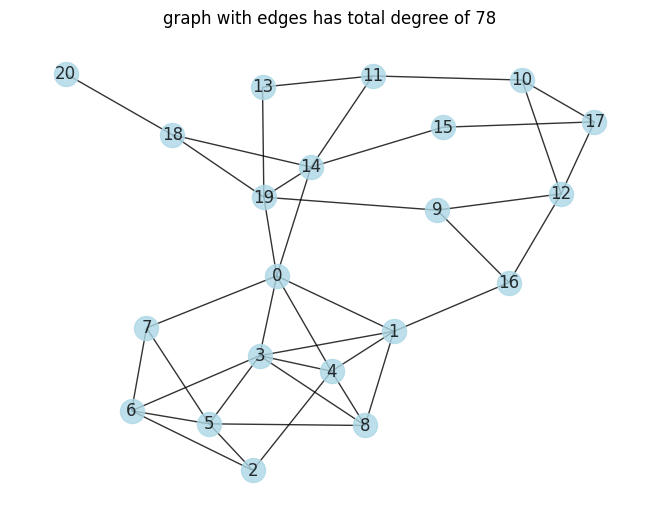

In [212]:
import networkx as nx
from drawing_utilities import show_graph
G = nx.Graph()
assortative_network._add_nodes_to_graph(G, all_nodes)
for edge_type in wired_edges.keys():
    assortative_network._add_edges_to_graph(G, wired_edges[edge_type])
show_graph(G, title=f"graph with edges has total degree of {sum(dict(G.degree()).values())}")

---

#### Step 2: Rewire

Wiring produces a graph with two potential problems.
- The graph might be disonnected
- Some of the required edge types might not have been added to the network

Let's look at what nodes weren't used.

In [213]:
print(available_stubs)

{0: [Node_Type(ID=0, degree=1, node_type=0), Node_Type(ID=3, degree=2, node_type=0), Node_Type(ID=3, degree=2, node_type=0), Node_Type(ID=4, degree=1, node_type=0)], 1: [Node_Type(ID=9, degree=1, node_type=1), Node_Type(ID=16, degree=2, node_type=1), Node_Type(ID=16, degree=2, node_type=1), Node_Type(ID=18, degree=2, node_type=1), Node_Type(ID=18, degree=2, node_type=1), Node_Type(ID=19, degree=1, node_type=1)]}


Let's look at what edge_types weren't added

In [217]:
print(f"unwired edges are {unwired_edge_types}")
for node in all_nodes:
    if node.degree > 0:
        print(f"degree of node {node.ID} is {node.degree}")

unwired edges are [(0, 0), (1, 1), (1, 1), (0, 0), (1, 1)]
degree of node 0 is 1
degree of node 3 is 2
degree of node 4 is 1
degree of node 9 is 1
degree of node 16 is 2
degree of node 18 is 2
degree of node 19 is 1


One situation that can occur is that we are left with an edge type where both ends of the edge are the same type. We can fix this by traversing the graph to find an edge such that both ends of this edge are the same type but have free degrees.

In [220]:
for edge_type in unwired_edge_types:
    if edge_type[0] == edge_type[1]:
        print(f"unused stubs of type {edge_type[0]} are {[stub.ID for stub  in available_stubs[edge_type[0]]]}")


unused stubs of type 0 are [0, 3, 3, 4]
unused stubs of type 1 are [9, 16, 16, 18, 18, 19]
unused stubs of type 1 are [9, 16, 16, 18, 18, 19]
unused stubs of type 0 are [0, 3, 3, 4]
unused stubs of type 1 are [9, 16, 16, 18, 18, 19]


These types of stubs could not be added because whey they were randomly paired there was already an edge between nodes of these types.

- for each edge type
  - for each end of the edge, traverse the graph and find edges with an endpoint that
    - is within the class
    - isn't connected to one of the unused stubs
